In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip '/content/gdrive/My Drive/Movies/posters.zip'
# !unzip '/content/gdrive/My Drive/Movies/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: posters/posters/79322.jpg  
  inflating: posters/posters/79336.jpg  
  inflating: posters/posters/79340.jpg  
  inflating: posters/posters/79355.jpg  
  inflating: posters/posters/79357.jpg  
  inflating: posters/posters/79359.jpg  
  inflating: posters/posters/79362.jpg  
  inflating: posters/posters/79366.jpg  
  inflating: posters/posters/79367.jpg  
  inflating: posters/posters/79368.jpg  
  inflating: posters/posters/79371.jpg  
  inflating: posters/posters/79378.jpg  
  inflating: posters/posters/79411.jpg  
  inflating: posters/posters/79417.jpg  
  inflating: posters/posters/79428.jpg  
  inflating: posters/posters/79429.jpg  
  inflating: posters/posters/79432.jpg  
  inflating: posters/posters/794338.jpg  
  inflating: posters/posters/794350.jpg  
  inflating: posters/posters/79437.jpg  
  inflating: posters/posters/794374.jpg  
  inflating: posters/posters/79445.jpg  
  inflating: posters/posters/79450.jpg  
  i

**IMPORTS**

In [14]:
import pandas as pd
import numpy as np
import io
import sys
import os.path
import urllib.request
from tqdm import tqdm
from os import listdir
from PIL import Image
import glob
import math
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import pyplot
import cv2
from keras import models
from keras import layers
from keras import optimizers
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
from statistics import mean
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K


In [15]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [16]:
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=sys.maxsize)

df = pd.read_csv("./gdrive/My Drive/Movies/MovieGenre.csv",encoding='ISO-8859-1')
df.head()

bad_images = []

print("Number of corrupt files:", len(bad_images))

image_list = []
for file in glob.glob("./posters/posters/*.jpg"):
    image_list.append(file)

print("Number of files found:", len(image_list))

image_paths = []
imdb_id = []
genres = []
titles = []

directory = './posters/posters/'
id_list = []

for filename in glob.iglob(f'{directory}/*'):
    f = filename.split('/')
    img_id = f[-1][:-4]   
    title = df[df["imdbId"] == int(img_id)]["Title"].values[0]
    genre = df[df["imdbId"] == int(img_id)]["Genre"].values[0]
    
    image_paths.append(filename)
    imdb_id.append(img_id)
    genres.append(genre)
    titles.append(title)

    
df_2 = pd.DataFrame({'imdbId': imdb_id, 'Genre': genres, 'Title': titles, 'Image_Paths': image_paths})

columnsTitles = ['Image_Paths','imdbId','Genre','Title']
df_2 = df_2.reindex(columns=columnsTitles)
df_2.head()

df_2.to_csv("./MovieGenre_final.csv", index = None)

Original_ID_list = np.asarray(df['imdbId']).astype(int)
ID_with_images_found = np.asarray(df_2['imdbId']).astype(int)

#Original lengths of the two arrays 
print("ORIGINAL:", len(Original_ID_list))
print("TRIMMED:", len(ID_with_images_found))

#First compare the unique values of these two arrays
uniq1, counts1 = np.unique(Original_ID_list, return_counts=True)
print("#unique ID values in ORIGINAL:", len(uniq1))

uniq2, counts2 = np.unique(ID_with_images_found, return_counts=True)
print("#unique ID values in TRIMMED:", len(uniq2))


non_unique_id = []
for i in range(len(counts1)):
    
    if (counts1[i]>1):
        #print(uniq1[i], "with freq=", counts1[i])
        non_unique_id.append(uniq1[i])
        
#print(non_unique_id)

#Find rows where the column value of imdb is among these non_unique_id values
for i in range(len(non_unique_id)):

    print(df.loc[df['imdbId'] == int(non_unique_id[i])])



Streaming output truncated to the last 5000 lines.
       IMDB Score                 Genre  \
12286         6.6  Crime|Drama|Thriller   
12880         6.6  Crime|Drama|Thriller   

                                                                                                                                  Poster  
12286  https://images-na.ssl-images-amazon.com/images/M/MV5BMjE3MDQxNTkxNF5BMl5BanBnXkFtZTcwNzYzMzgxMQ@@._V1_UY268_CR3,0,182,268_AL_.jpg  
12880  https://images-na.ssl-images-amazon.com/images/M/MV5BMjE3MDQxNTkxNF5BMl5BanBnXkFtZTcwNzYzMzgxMQ@@._V1_UY268_CR3,0,182,268_AL_.jpg  
       imdbId                           Imdb Link                 Title  \
12434  106579  http://www.imdb.com/title/tt106579  Clean, Shaven (1993)   
13028  106579  http://www.imdb.com/title/tt106579  Clean, Shaven (1993)   

       IMDB Score        Genre  \
12434         7.2  Crime|Drama   
13028         7.2  Crime|Drama   

                                                                         

In [17]:
df = pd.read_csv("./MovieGenre_final.csv",encoding='ISO-8859-1')

df.head()

def find_genres(genre):
    start = 0
    set_of_genre = []
    for i in range(len(genre)):
        
        k=0
        substring = ""
        if (genre[i]=='|'):
            substring = genre[start:i]
            start = i+1
            k = 1
        
        if(i==len(genre)-1):
            substring = genre[start:i+1]
            k = 1
            
        if (k==1):
            set_of_genre.append(substring)         
    
    return (set_of_genre)

all_genre = []
Genre_list = df['Genre']

for i in range (len(Genre_list)):
    if(pd.isnull(Genre_list[i])):
      continue
    
    set_of_genre = find_genres(Genre_list[i])
    
    for j in range (len(set_of_genre)):
        all_genre.append(set_of_genre[j])
        
uniq, counts = np.unique(all_genre, return_counts=True)
print("Number of unique genres:", len(uniq))
print("Unique genres are:", uniq)
dict(zip(uniq, counts))
cnts = np.zeros(28)
for i in range(28):
  cnts[i] = counts[i]


Number of unique genres: 28
Unique genres are: ['Action' 'Adult' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Family' 'Fantasy' 'Film-Noir' 'Game-Show'
 'History' 'Horror' 'Music' 'Musical' 'Mystery' 'News' 'Reality-TV'
 'Romance' 'Sci-Fi' 'Short' 'Sport' 'Talk-Show' 'Thriller' 'War' 'Western']


In [18]:
# Prepare multi-hot-encoded-labels for the various genres
def multi_hot_encoded_labels(img_id, genre):
    
    col_names =  ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
                  'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
                  'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
    
    set_of_genre = find_genres(genre)
    
    row=[]
    row.append(img_id)
    
    for i in range(len(col_names)):
        
        found = 0
        for j in range (len(set_of_genre)):
            if (set_of_genre[j]==col_names[i]):
                found = 1
                break
        
        row.append(found)
    
    row.append(genre) #add the overall combined genre for record purposes
        
    return row 


# Perform the encoding of the labels and save data in the format :
# Img-ID  overall_genre

df = pd.read_csv("MovieGenre_final.csv", encoding="ISO-8859-1")
all_data = []

for index, row in tqdm(df.iterrows()):
    
    path = row['Image_Paths']
    genre = row['Genre']
    if(pd.isnull(genre)):
      continue
    row = multi_hot_encoded_labels(path, genre)
    
    all_data.append(row)

col_names =  ['Img-paths', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
                  'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
                  'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', 'Genre']

np.savetxt("Multi_hot_encoded_data.csv", np.asarray(all_data), fmt='%s', delimiter=" ")   
np.savetxt("Encoded_data_column_lookup.csv", np.asarray(col_names), fmt='%s', delimiter=" ")

39515it [00:02, 13788.41it/s]


In [19]:
df_encoded = pd.read_csv("Multi_hot_encoded_data.csv", delimiter=" ", 
                  names =  ['Img-paths', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
                  'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
                  'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', 'Genre'])

df_encoded.head()

,Img-paths,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Genre
0,./posters/posters/281176.jpg,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,Comedy|Drama
1,./posters/posters/110932.jpg,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Biography|Drama|History
2,./posters/posters/2646378.jpg,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Horror|Sci-Fi
3,./posters/posters/475243.jpg,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Drama
4,./posters/posters/67445.jpg,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Drama


In [20]:
# To split into train / validation / test in the ratio 80 / 15 / 5%

df = pd.read_csv("Multi_hot_encoded_data.csv", delimiter=" ")
np.savetxt("Data.csv", df, fmt='%s', delimiter=" ")

# df = pd.read_csv("Multi_hot_encoded_data.csv", delimiter=" ")
# random_seed = 50
# train_df = df.sample(frac=0.7, random_state=random_seed) #Taking 70% of the data
# tmp_df = df.drop(train_df.index)
# test_df = tmp_df.sample(frac=0.1, random_state=random_seed) #Taking 20% of the remaining (after train is taken)
# valid_df = tmp_df.drop(test_df.index)

# print("Train_df=",len(train_df))
# print("Val_df=",len(valid_df))
# print("Test_df=",len(test_df))

# np.savetxt("Train.csv", train_df, fmt='%s', delimiter=" ")
# np.savetxt("Test.csv", test_df, fmt='%s', delimiter=" ")
# np.savetxt("Valid.csv", valid_df, fmt='%s', delimiter=" ")

# #Numpy method
# #train, validate, test = np.split(df_encoded.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
# #np.split will split at 60% of the length of the shuffled array, 
# #then 80% of length (which is an additional 20% of data), thus leaving a remaining 20% of the data.

In [21]:
def arrange_data(df,s):
    
    image_data_train = []
    image_data_val = []
    image_data_test = []
    img_paths = np.asarray(df.iloc[:, 0]) #First column is the image paths
    img_encode = np.asarray(df.iloc[:, 1:29])
    print(img_encode.shape)
    print(img_encode[0,1])
    # count=0
    # print(len(img_paths))
    count_vec_train = np.zeros(28)
    count_vec_val = np.zeros(28)
    count_vec_test = np.zeros(28)
    for i in tqdm(range(len(img_paths))):
              
        # img = image.load_img(img_paths[i],target_size=(200,150,3))
        # img = image.img_to_array(img)
        # print(img_paths[i])
        try:
            a_train = True
            a_val = True
            a_test = True
            for j in range(28):
              # print(count_vec_train[j])
              # print(j)
              if img_encode[i,j]==1 and cnts[j]//8<=count_vec_train[j]:
                a_train = False
            if a_train:
              count_vec_train += img_encode[i]
              img = keras.utils.load_img(img_paths[i],target_size=(200,150,3))
              img = keras.utils.img_to_array(img)
              img = img/255
              image_data_train.append(img)
              # print("sdkjhflk")
              continue
            for j in range(len(cnts)):
              if img_encode[i,j]==1 and cnts[j]//40<=count_vec_val[j]:
                a_val = False
            if a_val:
              count_vec_val += img_encode[i]
              img = keras.utils.load_img(img_paths[i],target_size=(200,150,3))
              img = keras.utils.img_to_array(img)
              img = img/255
              image_data_val.append(img)
              continue
            for j in range(len(cnts)):
              if img_encode[i,j]==1 and cnts[j]//40<=count_vec_test[j]:
                a_test = False
            if a_test:
              count_vec_test += img_encode[i]
              img = keras.utils.load_img(img_paths[i],target_size=(200,150,3))
              img = keras.utils.img_to_array(img)
              img = img/255
              image_data_test.append(img)
              continue
            else:
              continue
        except:
          continue
        count+=1
        # if(s=="train" and count==5000):
        #   break
        # elif(s=="val" and count==2500):
        #   break
    
    X_train = np.array(image_data_train)
    Y_train = np.array(df.iloc[:X_train.shape[0],1:29])
    X_val = np.array(image_data_val)
    Y_val = np.array(df.iloc[:X_val.shape[0],1:29])
    X_test = np.array(image_data_test)
    Y_test = np.array(df.iloc[:X_test.shape[0],1:29])
    
    # print("Shape of images:", X.shape)
    # print("Shape of labels:", Y.shape)
    
    return X_train, Y_train,X_val,Y_val,X_test,Y_test

print("Processing data..")
data_df = pd.read_csv("Data.csv", delimiter=" ")
X_train, Y_train, X_val, Y_val, X_test, Y_test = arrange_data (data_df,"data")
print("asdkgl")
print(X_train.shape[0])
print(X_test.shape[0])
print(X_val.shape[0])


# def arrange_data(df,s):
    
#     image_data = []
#     img_paths = np.asarray(df.iloc[:, 0]) #First column is the image paths
#     count=0

#     for i in tqdm(range(len(img_paths))):
              
#         # img = image.load_img(img_paths[i],target_size=(200,150,3))
#         # img = image.img_to_array(img)
#         # print(img_paths[i])
#         try:
#           img = keras.utils.load_img(img_paths[i],target_size=(200,150,3))
#           img = keras.utils.img_to_array(img)
#         except:
#           continue
#         # count+=1
#         # if(s=="train" and count==5000):
#         #   break
#         # elif(s=="val" and count==2500):
#         #   break
#         img = img/255
#         image_data.append(img)
        
        
    
#     X = np.array(image_data)
#     Y = np.array(df.iloc[:X.shape[0],1:29])
    
#     print("Shape of images:", X.shape)
#     print("Shape of labels:", Y.shape)
    
#     return X, Y

# print("Processing train..")
# train_df = pd.read_csv("Train.csv", delimiter=" ")
# X_train, Y_train = arrange_data (train_df,"train")

# print("Processing valid..")
# val_df = pd.read_csv("Valid.csv", delimiter=" ")
# X_val, Y_val = arrange_data (val_df,"val")

# print("Processing test..")
# test_df = pd.read_csv("Test.csv", delimiter=" ")
# X_test, Y_test = arrange_data (test_df,"test")

Processing data..
(39368, 28)
0


100%|██████████| 39368/39368 [00:09<00:00, 4009.72it/s] 


asdkgl
4906
947
968


CNN Model

In [22]:
num_classes = 28  

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(200,150,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 146, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 73, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 73, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 69, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 34, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 47, 34, 32)        0

Epoch 1/100
154/154 [==============================] - 16s 38ms/step - loss: 0.3321 - accuracy: 0.1527 - val_loss: 0.2350 - val_accuracy: 0.2345
Epoch 2/100
154/154 [==============================] - 5s 33ms/step - loss: 0.2439 - accuracy: 0.2344 - val_loss: 0.2130 - val_accuracy: 0.2345
Epoch 3/100
154/154 [==============================] - 6s 37ms/step - loss: 0.2345 - accuracy: 0.2354 - val_loss: 0.2115 - val_accuracy: 0.2345
Epoch 4/100
154/154 [==============================] - 5s 35ms/step - loss: 0.2295 - accuracy: 0.2444 - val_loss: 0.2120 - val_accuracy: 0.2345
Epoch 5/100
154/154 [==============================] - 5s 34ms/step - loss: 0.2267 - accuracy: 0.2446 - val_loss: 0.2110 - val_accuracy: 0.2345
Epoch 6/100
154/154 [==============================] - 5s 33ms/step - loss: 0.2248 - accuracy: 0.2440 - val_loss: 0.2106 - val_accuracy: 0.2345
Epoch 7/100
154/154 [==============================] - 5s 32ms/step - loss: 0.2236 - accuracy: 0.2436 - val_loss: 0.2108 - val_accuracy

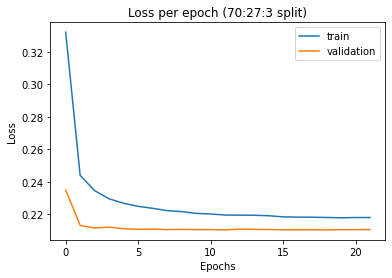

31/31 [==============================] - 1s 15ms/step
cnn accuracy (validation)=  48.553719008264466 %
30/30 [==============================] - 1s 17ms/step
cnn accuracy (test)=  48.89123548046462 %


In [23]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train, Y_train, epochs = 20,validation_data=(X_val,Y_val),batch_size=32)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history=model.fit(X_train, Y_train, epochs = 100,validation_data=(X_val,Y_val),batch_size=32, verbose=1, callbacks=[callback])
# history=model.fit(X_train, Y_train, epochs = 20,validation_data=(X_val,Y_val),batch_size=32)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per epoch (70:27:3 split)")
plt.show()

score = 0
# print(model.predict(X_val))
preds = np.argmax(model.predict(X_val),axis=1)


for img_no in range(X_val.shape[0]):
  if(Y_val[img_no,preds[img_no]]==1):
    score+=1

print('cnn accuracy (validation)= ', (score/X_val.shape[0])*100, '%')
score = 0
# print(model.predict(X_val))
preds = np.argmax(model.predict(X_test),axis=1)


for img_no in range(X_test.shape[0]):
  if(Y_test[img_no,preds[img_no]]==1):
    score+=1

print('cnn accuracy (test)= ', (score/X_test.shape[0])*100, '%')

KNN Model


In [24]:
from sklearn.neighbors import KNeighborsClassifier

score=0

accuracy=[]
k_list=[1,2,5,10,25,50,100,250,500]

for i in k_list:
  # print(i)
  knn = KNeighborsClassifier(n_neighbors=i)

  X_train_KNN=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
  X_val_KNN=X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]*X_val.shape[3]))

  knn.fit(X_train_KNN, Y_train)
  y_pred = knn.predict(X_val_KNN)

  accuracy.append(np.mean(np.sum(y_pred*Y_val,axis=1))*100)

print(accuracy)



[43.595041322314046, 11.466942148760332, 24.276859504132233, 12.190082644628099, 18.801652892561986, 13.842975206611571, 12.8099173553719, 12.396694214876034, 12.8099173553719]


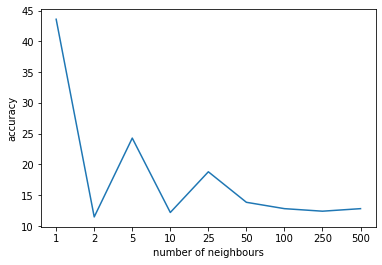

In [25]:
k_list=['1','2','5','10','25','50','100','250','500']

plt.plot(k_list, accuracy)
plt.xlabel("number of neighbours")
plt.ylabel("accuracy")
plt.show()

#best k= 1 or 5

# New section

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D
from keras.layers import Activation, Dropout
from keras.optimizers import Adam

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/100
154/154 [==============================] - 18s 92ms/step - loss: 0.3114 - accuracy: 0.1716 - val_loss: 0.2160 - val_accuracy: 0.2345
Epoch 2/100
154/154 [==============================] - 12s 80ms/step - loss: 0.2164 - accuracy: 0.2440 - val_loss: 0.2115 - val_accuracy: 0.2345
Epoch 3/100
154/154 [==============================] - 12s 81ms/step - loss: 0.2159 - accuracy: 0.2440 - val_loss: 0.2106 - val_accuracy: 0.2345
Epoch 4/100
154/154 [==============================] - 12s 81ms/step - loss: 0.2154 - accuracy: 0.2440 - val_loss: 0.2111 - val_accuracy: 0.2345
Epoch 5/100
154/154 [==============================] - 13s 86ms/step - loss: 0.2153 - accuracy: 0.2444 - val_loss: 0.2112 - val_accuracy: 0.2345
Epoch 6/100
154/154 [==============================] - 12s 81ms/step - loss: 0.2152 - accuracy: 0.2444 - val_loss: 0.2107 - val_accuracy: 0.2428
Epoch 7/100
154/154 [==============================] - 13s 81ms/s

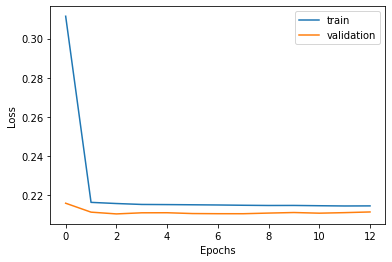

In [27]:
# Experiment 1 Resnet pretrained but not trained further 

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200,150,3),
                   pooling='avg',classes=32,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(28, activation='softmax'))
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history=resnet_model.fit(X_train, Y_train, epochs = 100,validation_data=(X_val,Y_val),batch_size=32, verbose=1, callbacks=[callback])

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
pyplot.legend()
pyplot.show()

# resnet_model.fit(img, y, epochs = 100,validation_data=(img_val,y_val),batch_size=32)


In [28]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 32)                65568     
                                                                 
 dense_4 (Dense)             (None, 28)                924       
                                                                 
Total params: 23,654,204
Trainable params: 66,492
Non-trainable params: 23,587,712
_________________________________________________________________


In [29]:
score = 0
preds = np.argmax(resnet_model.predict(X_val),axis=1)
# print(np.choose(Y_val.T,preds).shape)
for img_no in range(X_val.shape[0]):
  if(Y_val[img_no,preds[img_no]]==1):
    score+=1
print('cnn accuracy(validation) = ', (score/X_val.shape[0])*100, '%')

score = 0
preds = np.argmax(resnet_model.predict(X_test),axis=1)
# print(np.choose(Y_val.T,preds).shape)
for img_no in range(X_test.shape[0]):
  if(Y_test[img_no,preds[img_no]]==1):
    score+=1
print('cnn accuracy(test) = ', (score/X_test.shape[0])*100, '%')

31/31 [==============================] - 3s 65ms/step
cnn accuracy(validation) =  48.553719008264466 %
30/30 [==============================] - 2s 80ms/step
cnn accuracy(test) =  48.89123548046462 %


Epoch 1/100
154/154 [==============================] - 43s 238ms/step - loss: 0.2354 - binary_accuracy: 0.9231 - val_loss: 0.2459 - val_binary_accuracy: 0.9248
Epoch 2/100
154/154 [==============================] - 35s 228ms/step - loss: 0.2163 - binary_accuracy: 0.9234 - val_loss: 0.2135 - val_binary_accuracy: 0.9244
Epoch 3/100
154/154 [==============================] - 35s 230ms/step - loss: 0.2148 - binary_accuracy: 0.9234 - val_loss: 0.2133 - val_binary_accuracy: 0.9244
Epoch 4/100
154/154 [==============================] - 36s 232ms/step - loss: 0.2124 - binary_accuracy: 0.9235 - val_loss: 0.2168 - val_binary_accuracy: 0.9244
Epoch 5/100
154/154 [==============================] - 36s 232ms/step - loss: 0.2090 - binary_accuracy: 0.9238 - val_loss: 0.2152 - val_binary_accuracy: 0.9244
Epoch 6/100
154/154 [==============================] - 36s 232ms/step - loss: 0.2043 - binary_accuracy: 0.9244 - val_loss: 0.2225 - val_binary_accuracy: 0.9244
Epoch 7/100
154/154 [===================

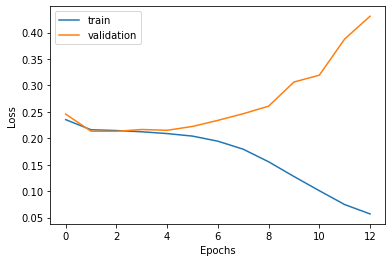

In [30]:
# Experiment 1 Resnet pretrained but not trained further 

resnet_model_1 = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200,150,3),
                   pooling='avg',classes=32,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=True

resnet_model_1.add(pretrained_model)
resnet_model_1.add(Flatten())
resnet_model_1.add(Dense(32, activation='relu'))
resnet_model_1.add(Dense(28, activation='softmax'))
resnet_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history=resnet_model_1.fit(X_train, Y_train, epochs = 100,validation_data=(X_val,Y_val),batch_size=32, verbose=1, callbacks=[callback])

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
pyplot.legend()
pyplot.show()


In [31]:
resnet_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 32)                65568     
                                                                 
 dense_6 (Dense)             (None, 28)                924       
                                                                 
Total params: 23,654,204
Trainable params: 23,601,084
Non-trainable params: 53,120
_________________________________________________________________


In [32]:
score = 0
preds = np.argmax(resnet_model_1.predict(X_val),axis=1)
# print(np.choose(Y_val.T,preds).shape)
for img_no in range(X_val.shape[0]):
  if(Y_val[img_no,preds[img_no]]==1):
    score+=1
print('cnn accuracy(validation) = ', (score/X_val.shape[0])*100, '%')

score = 0
preds = np.argmax(resnet_model_1.predict(X_test),axis=1)
# print(np.choose(Y_val.T,preds).shape)
for img_no in range(X_test.shape[0]):
  if(Y_test[img_no,preds[img_no]]==1):
    score+=1
print('cnn accuracy(test) = ', (score/X_test.shape[0])*100, '%')


31/31 [==============================] - 3s 65ms/step
cnn accuracy(validation) =  39.56611570247934 %
30/30 [==============================] - 2s 63ms/step
cnn accuracy(test) =  39.493136219640974 %


58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_7 (Dense)             (None, 1024)              12583936  
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 28)                28700     
                                                                 
Total params: 27,327,324
Trainable params: 19,692,060
Non-trainable params: 7,635,264
___________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/50
153/153 [==============================] - 41s 251ms/step - loss: 0.2448 - accuracy: 0.2257 - val_loss: 0.2130 - val_accuracy: 0.2345
Epoch 2/50
153/153 [==============================] - 37s 244ms/step - loss: 0.2276 - accuracy: 0.2409 - val_loss: 0.2114 - val_accuracy: 0.2345
Epoch 3/50
153/153 [==============================] - 36s 237ms/step - loss: 0.2234 - accuracy: 0.2435 - val_loss: 0.2122 - val_accuracy: 0.2345
Epoch 4/50
153/153 [==============================] - 37s 238ms/step - loss: 0.2217 - accuracy: 0.2460 - val_loss: 0.2129 - val_accuracy: 0.2345
Epoch 5/50
153/153 [==============================] - 36s 236ms/step - loss: 0.2209 - accuracy: 0.2458 - val_loss: 0.2115 - val_accuracy: 0.2345
Epoch 6/50
153/153 [==============================] - 36s 238ms/step - loss: 0.2195 - accuracy: 0.2462 - val_loss: 0.2126 - val_accuracy: 0.2345
Epoch 7/50
153/153 [==============================] - 36s 236ms/step - loss: 0.2188 - accuracy: 0.2462 - val_loss: 0.2137 - val_ac

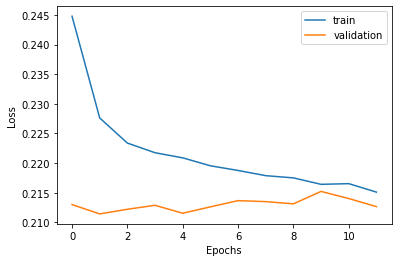

In [33]:
num_classes = 28  # Types of Genres

from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(200,150, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Create the model
VGG_model = models.Sequential()

# Add the vgg convolutional base model
VGG_model.add(vgg_conv)

num_classes = 28

# Add new layers
VGG_model.add(layers.Flatten())
VGG_model.add(layers.Dense(1024, activation='relu'))
VGG_model.add(layers.Dropout(0.5))
VGG_model.add(layers.Dense(num_classes, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
VGG_model.summary()

#model.compile(loss='binary_crossentropy',
              #optimizer=keras.optimizers.Adagrad(),
              #metrics=['accuracy'])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
VGG_model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2, 
                         shear_range=0.15,horizontal_flip=True, fill_mode="nearest")

# train the network
BS=32
EPOCHS=50
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# history = VGG_model.fit(X_train, Y_train, epochs = 20,validation_data=(X_val,Y_val),batch_size=32, verbose=1, callbacks=[callback])
history = VGG_model.fit(aug.flow(X_train, Y_train, batch_size=BS),validation_data=(X_val, Y_val), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS, callbacks=[callback])
# history = VGG_model.fit(X_train, Y_train, epochs = 50,validation_data=(X_val,Y_val),batch_size=32)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [34]:
score = 0
preds = np.argmax(VGG_model.predict(X_val),axis=1)
# print(np.choose(Y_val.T,preds).shape)
for img_no in range(X_val.shape[0]):
  if(Y_val[img_no,preds[img_no]]==1):
    score+=1
print('cnn accuracy(validation) = ', (score/X_val.shape[0])*100, '%')

score = 0
preds = np.argmax(VGG_model.predict(X_test),axis=1)
# print(np.choose(Y_val.T,preds).shape)
for img_no in range(X_test.shape[0]):
  if(Y_test[img_no,preds[img_no]]==1):
    score+=1
print('cnn accuracy(test) = ', (score/X_test.shape[0])*100, '%')

31/31 [==============================] - 3s 93ms/step
cnn accuracy(validation) =  47.93388429752066 %
30/30 [==============================] - 4s 143ms/step
cnn accuracy(test) =  47.72967265047519 %
